In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
# Define the date range
start_date = '2010-01-01'
end_date = '2024-05-13'

In [3]:
# Define the ticker
eur_usd_ticker = 'EURUSD=X'  # Yahoo Finance ticker for EUR/USD exchange rate

In [4]:
#Fetch historical data for EUR/USD exchange rate
try:    
    eur_usd_data = yf.download(eur_usd_ticker, start=start_date, end=end_date)
except Exception as e:
    print("Error fetching data:", e)
    exit()


[*********************100%%**********************]  1 of 1 completed


In [5]:
# Drop any rows with missing data in the interest rate data
eur_usd_data.dropna(inplace=True)

In [6]:
# Display the data
print("EUR/USD Exchange Rate Data:")
eur_usd_data

EUR/USD Exchange Rate Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0
2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0
2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0
2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0
...,...,...,...,...,...,...
2024-05-06,1.075812,1.079214,1.075639,1.075812,1.075812,0
2024-05-07,1.076751,1.078981,1.075581,1.076751,1.076751,0
2024-05-08,1.075049,1.075847,1.073572,1.075049,1.075049,0


In [7]:
# Create a SQLAlchemy engine
engine = create_engine('sqlite:///financial_data.db')

In [8]:
# Store data in SQL database
eur_usd_data.to_sql('eur_usd_data', engine, if_exists='replace', index=True)

3741

In [9]:
#Verify data stored in SQL database
with engine.connect() as conn:
    result = conn.execute("SELECT * FROM eur_usd_data LIMIT 5").fetchall()
    print("EUR/USD Data from SQL:")
    for row in result:
        print(row)

EUR/USD Data from SQL:
('2010-01-01 00:00:00.000000', 1.4327058792114258, 1.4401957988739014, 1.4327058792114258, 1.4389938116073608, 1.4389938116073608, 0)
('2010-01-04 00:00:00.000000', 1.4310041666030884, 1.4451910257339478, 1.4262080192565918, 1.4423978328704834, 1.4423978328704834, 0)
('2010-01-05 00:00:00.000000', 1.442710041999817, 1.4483097791671753, 1.4351937770843506, 1.4365959167480469, 1.4365959167480469, 0)
('2010-01-06 00:00:00.000000', 1.4365959167480469, 1.4434596300125122, 1.4291226863861084, 1.4404033422470093, 1.4404033422470093, 0)
('2010-01-07 00:00:00.000000', 1.4402996301651, 1.444481372833252, 1.430206060409546, 1.4318032264709473, 1.4318032264709473, 0)


Data Preparation and Cleaning

In [10]:
# Selecting features and target variable
eur_usd_data['Return'] = (eur_usd_data['Close']-eur_usd_data['Open'])/eur_usd_data['Open']
eur_usd_data.dropna(inplace=True)

In [11]:
eur_usd_data.head()

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2010-01-01,1.432706,1.440196,1.432706,1.438994,1.438994,0,0.004389
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0,0.007962
2010-01-05,1.442710,1.448310,1.435194,1.436596,1.436596,0,-0.004238
2010-01-06,1.436596,1.443460,1.429123,1.440403,1.440403,0,0.002650
2010-01-07,1.440300,1.444481,1.430206,1.431803,1.431803,0,-0.005899


In [12]:
# Features
X = eur_usd_data[['Open', 'High', 'Low', 'Volume', 'Return']]

In [13]:
# Target variable
y = eur_usd_data['Close']

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Normalize and standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Model Initialization and Training
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

SVR()

In [17]:
# Model Evaluation
y_pred = svr.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Initial SVR Model R-squared: {r2}")
print(f"Mean Squared Error: {mse}")


Initial SVR Model R-squared: 0.6936595026269144
Mean Squared Error: 0.004379987895846631


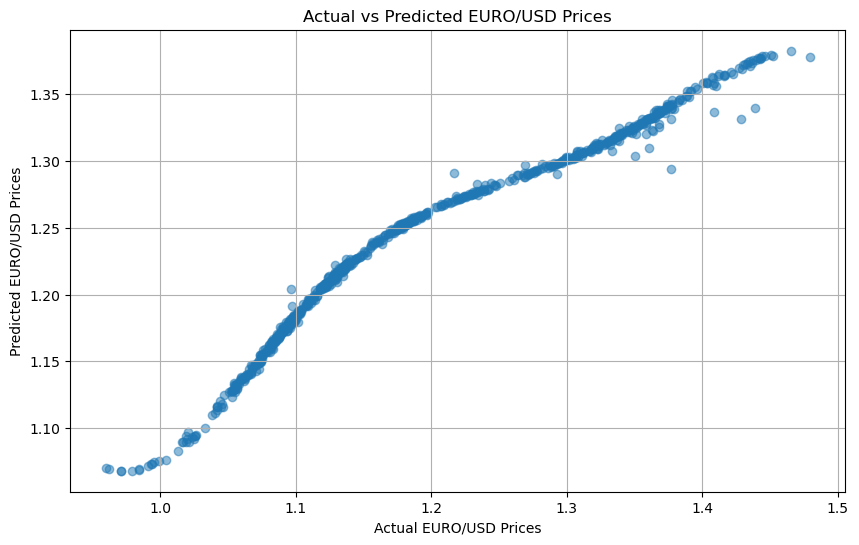

In [18]:
# Data Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual EURO/USD Prices')
plt.ylabel('Predicted EURO/USD Prices')
plt.title('Actual vs Predicted EURO/USD Prices')
plt.grid(True)
plt.show()

In [19]:
plt.savefig('/Data analytic boot camp/project4/true_vs_predicted_eur_usd_exchange_rate.png')


<Figure size 640x480 with 0 Axes>